<font size = 6>DNN solution to multi-period portfolio optimization - I.I.D case</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Dec 5, 2022</div></font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from numpy.random import multivariate_normal as mn
from cvxopt import matrix, solvers
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from sympy import Matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def state_trans(x, Rf):
    # auxiliary function of make_model function
    return (K.sum(x[0] * x[1], axis = 1, keepdims = True) + Rf + 1) * x[2]


def adjust_constraint(x, box):
    # auxiliary function of make_model function
    range = box[1] - box[0]
    multi_coef = range / 2
    add_coef = box[0] + multi_coef
    return x * multi_coef + add_coef


def get_layer_output(model, layer_name, input):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = keras.models.Model(inputs = model.input, outputs = layer_output)
    intermediate_prediction=intermediate_model.predict(input)
    return intermediate_prediction


def make_model(v, t, p, box, Rf):
    # Numebr of hidden layers in each step / subnetwork equals to 2.
    x = keras.Input(shape = (1,), name = "W_0")
    w = x
    inputs, ws = [w], []

    for i in range(t):
        x = layers.Dense(units = v, name = "L_" + str(i) + "_1", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = v, name = "L_" + str(i) + "_2", kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)
        x = layers.Dense(units = p, activation = "tanh", name = "tanh_" + str(i), kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform")(x)

        x = layers.Lambda(adjust_constraint, name = "g_" + str(i) , arguments = {"box" : box})(x) 
        input = keras.layers.Input(shape=(p, ), name = "Rk_" + str(i))
        x = layers.Lambda(state_trans, name = "W_" + str(i + 1), arguments = {"Rf" : Rf})([x, input, w]) 
        w = x

        inputs.append(input)
        ws.append(w)
    
    outputs = x
    return keras.Model(inputs, outputs)

# I.I.D Return Model

## Prepare the parameters

In [ ]:
# Number of samples in each step
n_1 = 20000
# Number of steps
s_1 = 100
# Number of risk assets
p_1_1, p_1_2, p_1_3 = 5, 50, 100
# Number of time period
t_1_1, t_1_2, t_1_3 = 40, 40, 30
# utility function parameter 
gamma_1_1, gamma_1_2, gamma_1_3 = 4, 5, 6
# box constraints
box_1_1, box_1_2, box_1_3 = [0, 1.5], [0, 0.5], [0, 0.5]

In [ ]:
# Mean vector of epsilons
mean_vec_1_1 = np.array([0] * p_1_1)
mean_vec_1_2 = np.array([0] * p_1_2)
mean_vec_1_3 = np.array([0] * p_1_3)
Matrix(mean_vec_1_1)

Matrix([
[0],
[0],
[0],
[0],
[0]])

In [ ]:
# Covariance matrix of epsilons
cov_matrix_1_1 = np.diag([1] * p_1_1)
cov_matrix_1_2 = np.diag([1] * p_1_2)
cov_matrix_1_3 = np.diag([1] * p_1_3)
Matrix(cov_matrix_1_1)

Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]])

In [ ]:
# Lambda vector of returns
lambda_vec_1_1 = np.array([0.1, 0.1, 0.2, 0.2, 0.2])
lambda_vec_1_2 = np.array([0.01] * 25 + [0.05] * 25)
lambda_vec_1_3 = np.array([0.01] * 50 + [0.05] * 50)
Matrix(lambda_vec_1_1)

Matrix([
[0.1],
[0.1],
[0.2],
[0.2],
[0.2]])

In [ ]:
# Volatility matrix of returns
sigma_matrix_1_1 = np.ones((p_1_1, p_1_1)) * 0.01
sigma_matrix_1_1 += np.diag([0.15 - 0.01] * p_1_1)
sigma_matrix_1_2 = np.ones((p_1_2, p_1_2)) * 0.005
sigma_matrix_1_2 += np.diag([0.15 - 0.005] * p_1_2)
sigma_matrix_1_3 = np.ones((p_1_3, p_1_3)) * 0.0025
sigma_matrix_1_3 += np.diag([0.15 - 0.0025] * p_1_3)
Matrix(sigma_matrix_1_1)

Matrix([
[0.15, 0.01, 0.01, 0.01, 0.01],
[0.01, 0.15, 0.01, 0.01, 0.01],
[0.01, 0.01, 0.15, 0.01, 0.01],
[0.01, 0.01, 0.01, 0.15, 0.01],
[0.01, 0.01, 0.01, 0.01, 0.15]])

## Prepare the functions

In [ ]:
#    Original steps by the author, which will cost a lot of memory when creating random numbers!!!
#    This method creates all the random variables at the beginning, which is not good for small memory machines.
#
#    def generate_input_1(port_num, samples, times, mean_vec, cov_matrix, lambda_vec, sigma_matrix, if_val, steps = 100, r = r):
#        # steps equal to 100 since we have to simulate the final samples
#        steps = 1  if  if_val  else steps
#        p, n, t, s, delta = port_num, samples, times, steps, 1/ times
#        # Generate random variables - epsilons
#        eps = mn(mean_vec, cov_matrix, t * s * n).reshape(t, n * s, p)
#        # Generate excess returns based on epsilons
#        coef = np.array([r] * p) + np.dot(sigma_matrix, lambda_vec) - 0.5 * np.diag(np.dot(sigma_matrix, sigma_matrix.T))
#        coef = np.repeat(coef, t * s * n).reshape(t, n * s, p)
#        left = coef * delta
#        right = np.sqrt(delta) * np.dot(eps, sigma_matrix)
#        random_matrix = np.exp(left + right) - np.exp(r * delta)
#        return random_matrix
#
#
#    def train_input_format(dataset, step_index, steps, samples, w_0 = 1):
#        # note: step_index starts with 1
#        # note: step_index equals to -1 when we want the whole dataset
#        if step_index == -1:
#            result = [np.array([[w_0] * dataset.shape[1]]).T]
#            for data in dataset:
#                result.append(data)
#        else:
#            if step_index > steps or step_index < 1:
#                raise Exception("step index is out of index!")
#            result = [np.array([[w_0] * samples]).T]
#            for data in dataset:
#                result.append(data[samples * (step_index - 1): samples * step_index])
#        return result
#
#
#    def train_output_format(dataset, samples, gamma, if_all):
#        if if_all == True:
#            result = np.array([[gamma / 2] * dataset.shape[1]]).T
#        else:
#            result = np.array([[gamma / 2] * samples]).T
#        return result
#
#
#    def val_input_output_format_1(dataset, gamma, w_0 = 1):
#        output = np.array([[gamma / 2] * dataset.shape[1]]).T
#        input = [np.array([[w_0] * dataset.shape[1]]).T]
#        for data in dataset:
#            input.append(data)
#        return input, output
#
#
#    def train_model_1(v, port_num, samples, times, steps, gamma, box, input_dataset, val_dataset): 
#        p, n, t, s= port_num, samples, times, steps
#        c, d = val_input_output_format_1(val_dataset, gamma)
#
#        m = make_model(v = v, t = t, p = p, box = box)
#        m.compile(
#            optimizer = keras.optimizers.Adam(learning_rate = 0.001),
#            loss = tf.keras.losses.MeanSquaredError())
#        
#        val_losses = []
#        for s_index in range(1, s + 1):
#            a = train_input_format(input_dataset, s_index, s, n)
#            b = train_output_format(input_dataset, n, gamma, False)
#            h = m.fit(x = a,  y = b, batch_size = 64, epochs=1, validation_data = [c, d], verbose = 1)
#            val_losses.append(h.history["val_loss"][0])
#
#        a = train_input_format(input_dataset, -1, s, n)
#        b = train_output_format(input_dataset, s, gamma, True)
#        h = m.fit(x = a,  y = b, batch_size = 64, epochs=1, validation_data = [c, d], verbose = 1)
#        val_losses.append(h.history["val_loss"][0])
#
#        return (m, val_losses)

In [ ]:
def generate_input_1(port_num, samples, times, mean_vec, cov_matrix, lambda_vec, sigma_matrix):
    # Annulized risk free rate 
    # which would be used in generating samples here -  i.i.d. case
    r = 0.03
    # steps equal to 100 since we have to simulate the final samples
    steps = 1
    # delta is the rebalancing time period
    p, n, t, s, delta = port_num, samples, times, steps, 1/ times
    # Generate random variables - epsilons
    eps = mn(mean_vec, cov_matrix, t * s * n).reshape(t, n * s, p)
    # Generate excess returns based on epsilons
    coef = np.array([r] * p) + np.dot(sigma_matrix, lambda_vec) - 0.5 * np.diag(np.dot(sigma_matrix, sigma_matrix.T))
    coef = np.repeat(coef, t * s * n).reshape(t, n * s, p)
    left = coef * delta
    right = np.sqrt(delta) * np.dot(eps, sigma_matrix)
    random_matrix = np.exp(left + right) - np.exp(r * delta)
    return random_matrix


def input_output_format_1(dataset, gamma, w_0 = 1):
    output = np.array([[gamma / 2] * dataset.shape[1]]).T
    input = [np.array([[w_0] * dataset.shape[1]]).T]
    for data in dataset:
        input.append(data)
    return input, output


def train_model_1(v, port_num, samples, times, steps, gamma, box, mean_vec, cov_matrix, lambda_vec, sigma_matrix, save_name, if_extra = False): 
    # Annulized risk free rate 
    # which would be used in generating samples here -  i.i.d. case
    r = 0.03
    p, n, t, s = port_num, samples, times, steps

    m = make_model(v = v, t = t, p = p, box = box, Rf = np.exp(r / t) - 1)
    m.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        loss = tf.keras.losses.MeanSquaredError())
    
    val_dataset = generate_input_1(p, n, t, mean_vec, cov_matrix, lambda_vec, sigma_matrix)
    c, d = input_output_format_1(val_dataset, gamma)
    val_losses = []

    for _ in range(1, s + 101 if if_extra else s + 1):
        input_dataset = generate_input_1(p, n, t, mean_vec, cov_matrix, lambda_vec, sigma_matrix)
        a, b = input_output_format_1(input_dataset, gamma)
        h = m.fit(x = a,  y = b, batch_size = 64, epochs=1, validation_data = [c, d], verbose = 1)
        val_losses.append(h.history["val_loss"][0])

    np.save("./result_1/" + save_name + ".npy", (m, val_losses))
    return (m, val_losses)

## Train Models

In [ ]:
#  result_1_1_1 = train_model_1(1, p_1_1, n_1, t_1_1, s_1, gamma_1_1, box_1_1, mean_vec_1_1, cov_matrix_1_1, lambda_vec_1_1, sigma_matrix_1_1, "result_1_1")
#  result_1_1_2 = train_model_1(5, p_1_1, n_1, t_1_1, s_1, gamma_1_1, box_1_1, mean_vec_1_1, cov_matrix_1_1, lambda_vec_1_1, sigma_matrix_1_1, "result_1_2")
#  result_1_1_3 = train_model_1(10, p_1_1, n_1, t_1_1, s_1, gamma_1_1, box_1_1, mean_vec_1_1, cov_matrix_1_1, lambda_vec_1_1, sigma_matrix_1_1, "result_1_3")
#  result_1_2_1 = train_model_1(1, p_1_2, n_1, t_1_2, s_1, gamma_1_2, box_1_2, mean_vec_1_2, cov_matrix_1_2, lambda_vec_1_2, sigma_matrix_1_2, "result_2_1")
#  result_1_2_2 = train_model_1(5, p_1_2, n_1, t_1_2, s_1, gamma_1_2, box_1_2, mean_vec_1_2, cov_matrix_1_2, lambda_vec_1_2, sigma_matrix_1_2, "result_2_2")
#  result_1_2_3 = train_model_1(20, p_1_2, n_1, t_1_2, s_1, gamma_1_2, box_1_2, mean_vec_1_2, cov_matrix_1_2, lambda_vec_1_2, sigma_matrix_1_2, "result_2_3")
#  result_1_3_1 = train_model_1(1, p_1_3, n_1, t_1_3, s_1, gamma_1_3, box_1_3, mean_vec_1_3, cov_matrix_1_3, lambda_vec_1_3, sigma_matrix_1_3, "result_3_1")
#  result_1_3_2 = train_model_1(5, p_1_3, n_1, t_1_3, s_1, gamma_1_3, box_1_3, mean_vec_1_3, cov_matrix_1_3, lambda_vec_1_3, sigma_matrix_1_3, "result_3_2")
#  result_1_3_3 = train_model_1(20, p_1_3, n_1, t_1_3, s_1, gamma_1_3, box_1_3, mean_vec_1_3, cov_matrix_1_3, lambda_vec_1_3, sigma_matrix_1_3, "result_3_3")

In [ ]:
# Read saved results
result_1_1_1 = np.load("result_1_1.npy", allow_pickle = True)
result_1_1_2 = np.load("result_1_2.npy", allow_pickle = True)
result_1_1_3 = np.load("result_1_3.npy", allow_pickle = True)
result_1_2_1 = np.load("result_2_1.npy", allow_pickle = True)
result_1_2_2 = np.load("result_2_2.npy", allow_pickle = True)
result_1_2_3 = np.load("result_2_3.npy", allow_pickle = True)
result_1_3_1 = np.load("result_3_1.npy", allow_pickle = True)
result_1_3_2 = np.load("result_3_2.npy", allow_pickle = True)
result_1_3_3 = np.load("result_3_3.npy", allow_pickle = True)

In [ ]:
# Check the models if necessary
#result_1_1_1[0].summary()
#keras.utils.plot_model(result_1_1_1[0], show_shapes=True)

## Show Results

In [ ]:
LSMC, HJB_1, HJB_2, HJB_3 = 0.827, 0.821, 2.032, 3.460
error_LSMC, error_HJB_5, error_HJB_50, error_HJB_100 = {}, {}, {}, {}

error_LSMC["1"] = (np.array(result_1_1_1[1]) - LSMC) / LSMC
error_LSMC["5"] = (np.array(result_1_1_2[1]) - LSMC) / LSMC
error_LSMC["10"] = (np.array(result_1_1_3[1]) - LSMC) / LSMC
error_HJB_5["1"] = (np.array(result_1_1_1[1]) - HJB_1) / HJB_1
error_HJB_5["5"] = (np.array(result_1_1_2[1]) - HJB_1) / HJB_1
error_HJB_5["10"] = (np.array(result_1_1_3[1]) - HJB_1) / HJB_1
error_HJB_50["1"] = (np.array(result_1_2_1[1]) - HJB_2) / HJB_2
error_HJB_50["5"] = (np.array(result_1_2_2[1]) - HJB_2) / HJB_2
error_HJB_50["20"] = (np.array(result_1_2_3[1]) - HJB_2) / HJB_2
error_HJB_100["1"] = (np.array(result_1_3_1[1]) - HJB_3) / HJB_3
error_HJB_100["5"] = (np.array(result_1_3_2[1]) - HJB_3) / HJB_3
error_HJB_100["20"] = (np.array(result_1_3_3[1]) - HJB_3) / HJB_3

error_LSMC = pd.DataFrame(error_LSMC, index = np.arange(1, 101))
error_HJB_5 = pd.DataFrame(error_HJB_5, index = np.arange(1, 101))
error_HJB_50 = pd.DataFrame(error_HJB_50, index = np.arange(1, 101))
error_HJB_100 = pd.DataFrame(error_HJB_100, index = np.arange(1, 101))

In [ ]:
error_HJB_5

,1,5,10
1,0.064773,0.044150,0.042267
2,0.053334,0.033232,0.033917
3,0.044981,0.027311,0.029486
4,0.039884,0.025371,0.026996
5,0.035654,0.023435,0.026965
...,...,...,...
96,0.017251,0.008855,0.014154
97,0.017039,0.009004,0.013489
98,0.016825,0.009746,0.013222
99,0.016824,0.010136,0.013033


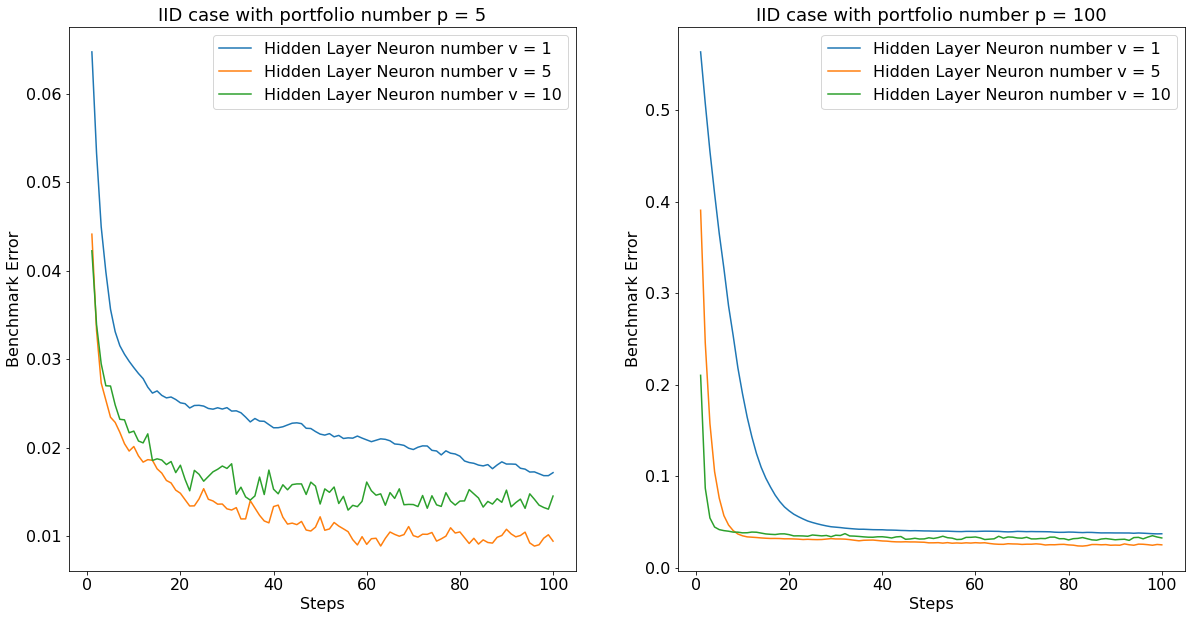

In [ ]:
#  fig = plt.figure(figsize=(10, 4));
#  ax3 = fig.add_subplot(1, 2, 1);
#  ax4 = fig.add_subplot(1, 2, 2);
#  ax3.plot(error_HJB_50.index, error_HJB_50);
#  ax4.plot(error_HJB_100.index, error_HJB_100);

fig = plt.figure(figsize=(20, 10));
ax1 = fig.add_subplot(1, 2, 1);

ax1.plot(error_HJB_5.index, error_HJB_5["1"], label = "Hidden Layer Neuron number v = 1");
ax1.plot(error_HJB_5.index, error_HJB_5["5"], label = "Hidden Layer Neuron number v = 5");
ax1.plot(error_HJB_5.index, error_HJB_5["10"], label = "Hidden Layer Neuron number v = 10");
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Benchmark Error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.title("IID case with portfolio number p = 5",fontsize = 18);

ax2 = fig.add_subplot(1, 2, 2);
ax2.plot(error_HJB_100.index, error_HJB_100["1"], label = "Hidden Layer Neuron number v = 1");
ax2.plot(error_HJB_100.index, error_HJB_100["5"], label = "Hidden Layer Neuron number v = 5");
ax2.plot(error_HJB_100.index, error_HJB_100["20"], label = "Hidden Layer Neuron number v = 10");
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Benchmark Error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.title("IID case with portfolio number p = 100",fontsize = 18);